# Objectif Global

Je dois reconstituer l'objet scanné en 3D à partir de deux séquences d'images (prises par deux caméras : gauches/doite).


## Etapes à réaliser 
- (Calibration des caméras)
-   j'utilise du damier (checkerboard) fournies dans le .zip
-   fonctions :
- cv2.findChessboardCorners() → détecter les coins.
- cv2.cornerSubPix() → affiner la précision.
- cv2.drawChessboardCorners() → vérifier visuellement.
- cv2.calibrateCamera() → obtenir :
-       la matrice intrinsèque K,
-       les vecteurs de rotation rvecs,
-       les vecteurs de translation tvecs.

ces paramètres me serviront pour obtenir les matrices de projection des deux caméras.




# 2 calcul de la matrice fondamentale F
- À partir des correspondances entre les deux images gauche/droite.
- Tu peux :
-   la calculer manuellement (avec les équations données)
-   directement utiliser cv2.findFundamentalMat().

Cette matrice me donne la contrainte épipolaire 

x′TFx=0


# 3 Calcul des droites épipolaires
Pour chaque point d’une image, trace la droite épipolaire correspondante dans l’autre.

Tu peux le vérifier en dessinant les lignes rouges (fonction de dessin OpenCV).

# 4 Recherche des correspondances (matching pairs)

Trouve les points correspondants entre l’image gauche et droite (par exemple via les lignes épipolaires).

Ces paires sont nécessaires pour reconstruire le 3D.


# 5 Triangulation des points 3D
Utilise cv2.triangulatePoints() avec les deux matrices de projection et les points correspondants.

Cela te donnera les coordonnées 3D du nuage de points.

# 6 Affichage du nuage de points 3D
Affiche le résultat (en 3D avec matplotlib ou Open3D).

C’est la reconstitution finale de ton objet scanné.



# Barème d'évaluation 

| Étape                           | Points |
| ------------------------------- | ------ |
| Projection matrices des caméras | 3      |
| Matrice fondamentale calculée   | 2      |
| Lignes rouges échantillonnées   | 1      |
| Lignes épipolaires calculées    | 2      |
| Paires correspondantes trouvées | 3      |
| Points 3D triangulés            | 3      |
| Nuage de points affiché         | 1      |
| Explications claires à l’oral   | 5      |


# Résumé ce que je dois faire concrètement

Charger les images de calibration.

Calibrer les deux caméras (trouver K, R, t).

Calculer ou vérifier la matrice fondamentale 
F
F.

Tracer les droites épipolaires.

Trouver les paires de points correspondants.

Trianguler les points 3D.

Afficher le nuage de points 3D.

Être capable d’expliquer chaque étape à l’oral.

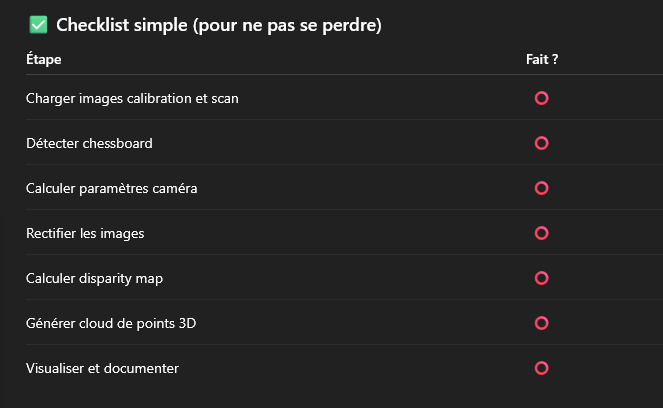

# imports (Initialisation)

Chargement des librairies et définition des dossiers

In [25]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
from pathlib import Path
import os, re

# 3D (nuage de points) — optionnel mais utile
from mpl_toolkits.mplot3d import Axes3D

# Affichage plus lisible dans le notebook
plt.rcParams["figure.figsize"] = (10, 6)


## Détection + raffinement subpixel des coins

In [85]:
def detect_chessboard_corners(image_path: Path, pattern_size):
    """
    Détecte les coins internes du damier, puis raffine en subpixel.
    Retour:
      - success : bool
      - image_with_corners : image RGB avec coins dessinés (si succès)
      - corners : (N,1,2) float32 si succès, sinon None
    """
    img_bgr = cv2.imread(str(image_path))
    if img_bgr is None:
        raise FileNotFoundError(f"Impossible de lire: {image_path}")

    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # Flags robustes (FAST_CHECK peut rater des images)
    flags = (cv2.CALIB_CB_ADAPTIVE_THRESH |
             cv2.CALIB_CB_NORMALIZE_IMAGE)

    success, corners = cv2.findChessboardCorners(gray, pattern_size, flags)

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb_with = img_rgb.copy()

    if not success:
        return {"success": False, "image_with_corners": img_rgb, "corners": None}

    # Raffinement subpixel
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-3)
    refined = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)

    cv2.drawChessboardCorners(img_rgb_with, pattern_size, refined, True)
    return {"success": True, "image_with_corners": img_rgb_with, "corners": refined}


## Test rapide sur une paire (sanity check)

DEBUG detection: Left=True | Right=True
Left corners shape: (49, 1, 2)
Right corners shape: (49, 1, 2)


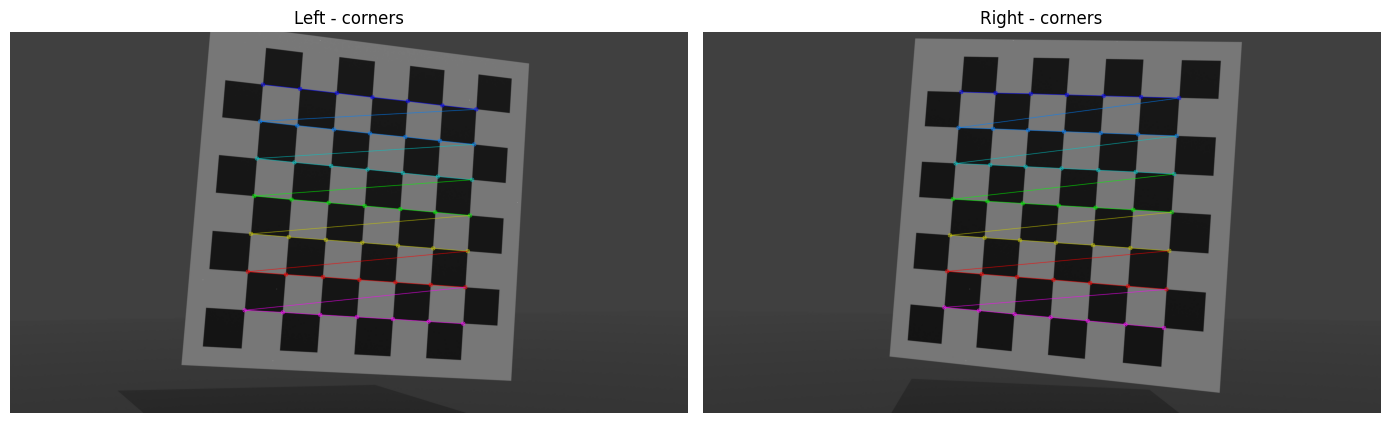

In [86]:
resL = detect_chessboard_corners(TEST_LEFT, pattern_size)
resR = detect_chessboard_corners(TEST_RIGHT, pattern_size)

print(f"DEBUG detection: Left={resL['success']} | Right={resR['success']}")
if resL["success"]:
    print("Left corners shape:", resL["corners"].shape)
if resR["success"]:
    print("Right corners shape:", resR["corners"].shape)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.imshow(resL["image_with_corners"]); ax1.set_title("Left - corners"); ax1.axis("off")
ax2.imshow(resR["image_with_corners"]); ax2.set_title("Right - corners"); ax2.axis("off")
plt.tight_layout(); plt.show()


### Grille 3D “objp” du damier (plan z=0)

In [87]:
def build_object_points(pattern_size, square_size):
    """
    Construit les points 3D du damier sur le plan z=0.
    pattern_size = (cols, rows) = nb coins intérieurs par ligne/colonne
    Retour: (N,3)
    """
    cols, rows = pattern_size
    objp = np.zeros((cols * rows, 3), np.float32)

    gx, gy = np.meshgrid(np.arange(cols), np.arange(rows))
    objp[:, :2] = np.column_stack((gx.ravel(), gy.ravel())) * square_size
    return objp


## Calibration mono (fonction)

In [90]:
def calibrate_camera(image_paths, pattern_size, square_size=1.0, min_valid=8):
    """
    Calibre UNE caméra à partir de plusieurs images du damier.
    Retour:
      - rms: erreur reprojection globale
      - K, dist
      - per_view_errors: erreur reprojection par image (utile pour filtrer)
      - used: images réellement utilisées
    """
    obj_points = []   # liste (N,3) par image
    img_points = []   # liste (N,1,2) par image
    used = []

    objp = build_object_points(pattern_size, square_size)
    image_size = None

    for p in image_paths:
        res = detect_chessboard_corners(p, pattern_size)
        if not res["success"]:
            continue

        img_bgr = cv2.imread(str(p))
        h, w = img_bgr.shape[:2]
        if image_size is None:
            image_size = (w, h)
        elif image_size != (w, h):
            raise ValueError(f"Taille image différente: {p} -> {(w,h)} vs {image_size}")

        obj_points.append(objp.copy())
        img_points.append(res["corners"])
        used.append(p)

    if len(used) < min_valid:
        raise ValueError(f"Pas assez d’images valides: {len(used)} (min {min_valid}).")

    rms, K, dist, rvecs, tvecs = cv2.calibrateCamera(
        obj_points, img_points, image_size, None, None
    )

    # Erreur reprojection par vue (diagnostic)
    per_view_errors = []
    for objp_i, imgp_i, rvec, tvec in zip(obj_points, img_points, rvecs, tvecs):
        proj, _ = cv2.projectPoints(objp_i, rvec, tvec, K, dist)
        err = np.sqrt(np.mean(np.sum((imgp_i - proj) ** 2, axis=2)))
        per_view_errors.append(float(err))

    return {
        "rms": float(rms),
        "K": K,
        "dist": dist,
        "used": used,
        "per_view_errors": per_view_errors,
        "mean_view_error": float(np.mean(per_view_errors)),
        "max_view_error": float(np.max(per_view_errors)),
        "image_size": image_size,
    }


## Lister les images et calibrer Left / Right

In [89]:
left_paths  = sorted(Path(p) for p in glob.glob(str(CB_DIR / "*Left*.png")))
right_paths = sorted(Path(p) for p in glob.glob(str(CB_DIR / "*Right*.png")))

print("Nb images Left :", len(left_paths))
print("Nb images Right:", len(right_paths))

calibL = calibrate_camera(left_paths, pattern_size, square_size)
calibR = calibrate_camera(right_paths, pattern_size, square_size)

print("\n=== CALIB LEFT ===")
print("RMS global:", calibL["rms"])
print("Mean view err:", calibL["mean_view_error"], " | Max:", calibL["max_view_error"])
print("K_L:\n", calibL["K"])
print("dist_L:", calibL["dist"].ravel())

print("\n=== CALIB RIGHT ===")
print("RMS global:", calibR["rms"])
print("Mean view err:", calibR["mean_view_error"], " | Max:", calibR["max_view_error"])
print("K_R:\n", calibR["K"])
print("dist_R:", calibR["dist"].ravel())


Nb images Left : 4
Nb images Right: 4


ValueError: Pas assez d’images valides: 3 (min 8).

## Vérification “norme” (simple à expliquer)

In [91]:
# Règle simple exigence prof (ton critère)
THRESH = 15.0

okL = calibL["rms"] < THRESH
okR = calibR["rms"] < THRESH

print(f"\nCheck RMS < {THRESH}px : Left={okL} | Right={okR}")

# Si RMS trop grand, tu peux identifier les pires vues :
def worst_views(calib, top=5):
    idx = np.argsort(calib["per_view_errors"])[::-1][:top]
    return [(calib["used"][i].name, calib["per_view_errors"][i]) for i in idx]

print("\nWorst Left views:", worst_views(calibL))
print("Worst Right views:", worst_views(calibR))


NameError: name 'calibL' is not defined

# Chargement des images pour la calibration

On charge les images du damier pour calibrer la caméra

# Paramètres 

In [26]:

# PARAMÈTRES GLOBAUX DU PROJET

# Taille du damier :
# 8x8 cases → 7x7 coins intérieurs détectables
pattern_size = (7, 7)

# Taille physique d’un carré
square_size = 1.0

# Dossier des images de calibration (chessboards)
CB_DIR = Path("data/chessboards")

# Le pattern size correspond au nombre de coins intérieurs du damier, et le square size définit l’échelle réelle

# ===============================
# PAIRE DE TEST (DEBUG)
# ===============================

TEST_LEFT  = CB_DIR / "c4Left.png"
TEST_RIGHT = CB_DIR / "c4Right.png"

# J’utilise une paire test pour valider la détection avant de lancer la calibration complète


# Detection corner

In [ ]:
def detect_chessboard_corners(image_path, pattern_size):
    """
    Détecte les coins internes du damier dans une image.

    Retour :
      - success (bool)
      - image_rgb : image RGB originale
      - image_with_corners : image RGB avec coins dessinés
      - corners : (N,1,2) float32 si succès, sinon None
    """
    # Read picture (on lit l'image BGR dans OpenCV)
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        raise FileNotFoundError(f"Impossible de lire: {image_path}")

    # Convert to grayscale (conversion en nivo de gris)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

    # detect the inner corners of the checkerboard
    # flag is any option to improve detection
    flags = (cv2.CALIB_CB_ADAPTIVE_THRESH | # seuillage adaptif (meilleure séparation noir/blanc)
             cv2.CALIB_CB_NORMALIZE_IMAGE | # normalisation avant detection (robusteuse)
             cv2.CALIB_CB_FAST_CHECK) # Test rapide 

    # success, corners = cv2.findChessboardCorners(image, patternSize, flags=None) 
    # we can use None but OpenCV read like default = lent et - robuste
    success, corners = cv2.findChessboardCorners(gray, pattern_size, flags)

    #  Read in RGB 
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_rgb_with = img_rgb.copy()


    if success:
        # improve corner precision and stopping criteria (max 30 iterations or epsilon 1e-3)
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

        # cornerSubPix refinement (rafinnage)
        refined_corners = cv2.cornerSubPix(gray, corners,
                                   winSize=(11, 11),
                                   zeroZone=(-1, -1),
                                   criteria=criteria)

        # Draw the corners on a copy for visual verif
        cv2.drawChessboardCorners(img_rgb_with, pattern_size, refined_corners, success)
        return  {
            "success": True,
            "image_rgb": img_rgb,
            "image_with_corners": img_rgb_with,
            "corners": refined_corners
        }
    else:
        return {
            "success": False,
            "image_rgb": img_rgb,
            "image_with_corners": img_rgb,  # Nothing to draw
            "corners": None
        }

# convert to graysacle, detect inner corners with "findChessboardCorners"
# then refine sub-pixel "conerSubPix" to gain precision.
# On détecte d’abord les coins entiers du damier, puis on raffine leur position à une précision sub-pixel


# Example


Corners detected in both images ! 
Left corners shape : (49, 1, 2)
Right corners shape: (49, 1, 2)


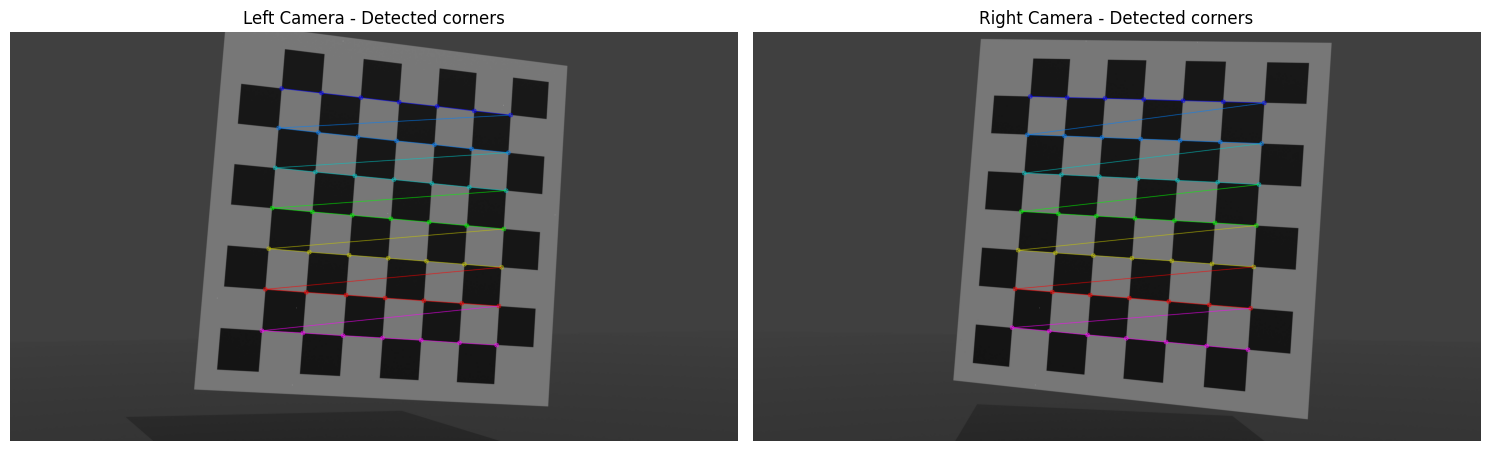

In [30]:
# simple test on a pair L/R
result_left  = detect_chessboard_corners(image_left,  pattern_size)
result_right = detect_chessboard_corners(image_right, pattern_size)

# display resultts
if result_left["success"] and result_right["success"]:
    print("Corners detected in both images ! ")
    print("Left corners shape :", result_left["corners"].shape)   # (N,1,2)
    print("Right corners shape:", result_right["corners"].shape)
else:
    print(f"Détection: Left={result_left['success']} | Right={result_right['success']}")

# display left image with corners
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.imshow(result_left["image_with_corners"])
ax1.set_title("Left Camera - Detected corners")
ax1.axis("off")

# display right image with corners
ax2.imshow(result_right["image_with_corners"])
ax2.set_title("Right Camera - Detected corners")
ax2.axis("off")

# show
plt.tight_layout()
plt.show()


# Calibration caméra (K, dist, R, t)

On détecte les coins sur plusieurs vues du damier, calibrateCamera calcul K, dist, et pour chaque vue (R, t); on en déduit P = K[R|t]

On détecte les coins du damier pour calibrer : calibrateCamera → K, dist, R, t.

In [32]:
def build_object_points(pattern_size, square_size):
    """
    Construit la grille 3D du damier sur le plan z=0.
    pattern_size = (cols, rows) = nb de coins intérieurs par ligne/colonne.
    Retour: objp (N,3), N = cols*rows
    """
    cols, rows = pattern_size
    objp = np.zeros((cols * rows, 3), np.float32)

    gx, gy = np.meshgrid(np.arange(cols), np.arange(rows))
    objp[:, :2] = np.column_stack((gx.ravel(), gy.ravel())) * square_size
    return objp


def calibrate_camera(img_list, pattern_size, square_size=1.0):
    """
    Calibre UNE caméra à partir de plusieurs vues du damier.
    Retourne: K, dist, rvecs, tvecs, P_list, erreurs, image_size, images utilisées.
    """
    obj_points = []        # liste de (N,3)
    img_points = []        # liste de (N,1,2)
    success_images = []

    objp = build_object_points(pattern_size, square_size)  # (N,3)

    image_size = None

    for path in img_list:
        res = detect_chessboard_corners(path, pattern_size)
        if not res["success"]:
            continue

        # Définir / vérifier la taille d’image
        img_bgr = cv2.imread(path)
        if img_bgr is None:
            continue
        size_now = (img_bgr.shape[1], img_bgr.shape[0])  # (w,h)

        if image_size is None:
            image_size = size_now
        elif size_now != image_size:
            raise ValueError(f"Images de tailles différentes: {path} a {size_now}, attendu {image_size}")

        obj_points.append(objp.copy())         # sécurité: copie
        img_points.append(res["corners"])      # (N,1,2)
        success_images.append(path)

    if len(success_images) < 3:
        raise ValueError(f"Pas assez d’images valides ({len(success_images)}) pour calibrer (min 3).")

    rms, K, dist, rvecs, tvecs = cv2.calibrateCamera(
        obj_points, img_points, image_size, None, None
    )

    P_list = []
    per_view_errors = []

    for objp_i, imgp_i, rvec, tvec in zip(obj_points, img_points, rvecs, tvecs):
        R, _ = cv2.Rodrigues(rvec)
        Rt = np.hstack((R, tvec.reshape(3, 1)))
        P = K @ Rt
        P_list.append(P)

        proj, _ = cv2.projectPoints(objp_i, rvec, tvec, K, dist)
        err = np.sqrt(np.mean(np.sum((imgp_i - proj) ** 2, axis=2)))
        per_view_errors.append(float(err))

    return {
        "rms": float(rms),
        "K": K,
        "dist": dist,
        "rvecs": rvecs,
        "tvecs": tvecs,
        "P_list": P_list,
        "success_images": success_images,
        "per_view_errors": per_view_errors,
        "image_size": image_size,
    }


# Example

In [33]:
# Construire la liste d’images (toutes les vues LEFT ou toutes les RIGHT)
left_images = sorted(glob.glob(str(CB_DIR / "*Left*.png"))) + sorted(glob.glob(str(CB_DIR / "*Left*.jpg")))
print("Found LEFT images:", len(left_images))

right_images = sorted(glob.glob(str(CB_DIR / "*Right*.png"))) + sorted(glob.glob(str(CB_DIR / "*Right*.jpg")))
print("Found RIGHT images:", len(right_images))

pattern_size = (7,7)  # 8x8 cases → 7x7 coins intérieurs
square_size  = 1.0    # Unité cohérente (mm ou cm)

# Calibration monoculaire
cal_left  = calibrate_camera(left_images,  pattern_size, square_size)
print(f"Successfully calibrated on {len(cal_left['success_images'])} LEFT images.")

cal_right = calibrate_camera(right_images, pattern_size, square_size)
print(f"Successfully calibrated on {len(cal_right['success_images'])} RIGHT images.")

# Résultats caméra gauche
print("\nLEFT RMS:", cal_left["rms"])
print("LEFT Intrinsic Matrix K:\n", cal_left["K"])
print("LEFT Distortion Coefficients:\n", cal_left["dist"].ravel())
print("Per-view Reprojection Errors (LEFT):", np.round(cal_left["per_view_errors"], 3))

# Résultats caméra droite
print("\nRIGHT RMS:", cal_right["rms"])
print("RIGHT Intrinsic Matrix K:\n", cal_right["K"])
print("RIGHT Distortion Coefficients:\n", cal_right["dist"].ravel())
print("Per-view Reprojection Errors (RIGHT):", np.round(cal_right["per_view_errors"], 3))



Found LEFT images: 4
Found RIGHT images: 4
Successfully calibrated on 3 LEFT images.
Successfully calibrated on 3 RIGHT images.

LEFT RMS: 0.03815122662778446
LEFT Intrinsic Matrix K:
 [[2.09914861e+03 0.00000000e+00 9.60349966e+02]
 [0.00000000e+00 2.09921598e+03 5.39168544e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
LEFT Distortion Coefficients:
 [-1.86159040e-03 -1.53161891e-02 -1.13620011e-04  1.72412392e-04
  1.11289112e+00]
Per-view Reprojection Errors (LEFT): [0.039 0.036 0.04 ]

RIGHT RMS: 0.040282515240613846
RIGHT Intrinsic Matrix K:
 [[2.09989379e+03 0.00000000e+00 9.59680444e+02]
 [0.00000000e+00 2.09976382e+03 5.39415149e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
RIGHT Distortion Coefficients:
 [-9.32192744e-03  3.56561896e-01 -6.83203569e-05 -4.83722425e-05
 -3.72283585e+00]
Per-view Reprojection Errors (RIGHT): [0.038 0.041 0.041]


In [35]:
# ===============================
# LISTE DES IMAGES DE CALIBRATION
# ===============================

left_images  = sorted(glob.glob(str(CB_DIR / "*Left*.png")) + glob.glob(str(CB_DIR / "*Left*.jpg")))
right_images = sorted(glob.glob(str(CB_DIR / "*Right*.png")) + glob.glob(str(CB_DIR / "*Right*.jpg")))

print("Found LEFT images :", len(left_images))
print("Found RIGHT images:", len(right_images))

if len(left_images) == 0 or len(right_images) == 0:
    raise FileNotFoundError("Aucune image trouvée dans data/chessboards. Vérifie CB_DIR et les noms de fichiers.")

if len(left_images) != len(right_images):
    print("⚠️ Attention: nombre d'images Left != Right. La calibration mono marche, mais la stéréo demandera des paires bien alignées.")

# ===============================
# CALIBRATION MONOCULAIRE
# ===============================

cal_left  = calibrate_camera(left_images,  pattern_size, square_size)
cal_right = calibrate_camera(right_images, pattern_size, square_size)

print(f"\n✅ Calibrated LEFT  using {len(cal_left['success_images'])} valid images.  RMS = {cal_left['rms']:.6f} px")
print(f"✅ Calibrated RIGHT using {len(cal_right['success_images'])} valid images. RMS = {cal_right['rms']:.6f} px")

# Résultats caméra gauche
print("\n--- LEFT camera ---")
print("K =\n", cal_left["K"])
print("dist =", cal_left["dist"].ravel())
print("per-view errors =", np.round(cal_left["per_view_errors"], 4))

# Résultats caméra droite
print("\n--- RIGHT camera ---")
print("K =\n", cal_right["K"])
print("dist =", cal_right["dist"].ravel())
print("per-view errors =", np.round(cal_right["per_view_errors"], 4))


Found LEFT images : 4
Found RIGHT images: 4

✅ Calibrated LEFT  using 3 valid images.  RMS = 0.038151 px
✅ Calibrated RIGHT using 3 valid images. RMS = 0.040283 px

--- LEFT camera ---
K =
 [[2.09914861e+03 0.00000000e+00 9.60349966e+02]
 [0.00000000e+00 2.09921598e+03 5.39168544e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist = [-1.86159040e-03 -1.53161891e-02 -1.13620011e-04  1.72412392e-04
  1.11289112e+00]
per-view errors = [0.0389 0.0357 0.0397]

--- RIGHT camera ---
K =
 [[2.09989379e+03 0.00000000e+00 9.59680444e+02]
 [0.00000000e+00 2.09976382e+03 5.39415149e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist = [-9.32192744e-03  3.56561896e-01 -6.83203569e-05 -4.83722425e-05
 -3.72283585e+00]
per-view errors = [0.0384 0.0412 0.0412]


### Étape 0 — Paramètres & données
- pattern_size = (7,7)
- square_size = 1.0
- dossiers : chessboards/, scanLeft/, scanRight/

But : avoir les chemins et la géométrie du damier.

### Étape 1 — Détection coins (fonction)

- detect_chessboard_corners(image_path, pattern_size)
But : obtenir les coins 2D (sub-pixel).

### Étape 2 — Calibration MONO (une caméra à la fois)
Tu l’as fait :

- cal_left = calibrate_camera(left_images, ...)

- cal_right = calibrate_camera(right_images, ...)

Tu obtiens :

- K_left, dist_left

- K_right, dist_right

- pour chaque image : rvecs, tvecs (pose du damier)

Calibration mono = paramètres intrinsèques + distorsion de chaque caméra

### Étape 3 — Pairing L/R + collecte stéréo

Tu l’as fait :

- pairs = pair_left_right(CB_DIR)

- obj_pts, img_ptsL, img_ptsR, used_pairs, imsize = collect_stereo_points(...)

But : préparer exactement les listes nécessaires à la stéréo.

### Étape 4 — Calibration STÉRÉO (le “vrai stéréo”)
C’est ici que tu es bloqué mentalement.

Pourquoi ?

Parce que tu te dis : “j’ai déjà K, pourquoi je refais une calibration ?”

Réponse :

Calibration mono donne l’optique interne de chaque caméra (K, dist)

Calibration stéréo donne la position relative entre les deux caméras :

R (rotation gauche→droite)

T (translation gauche→droite)

Sans R,T, tu ne peux pas reconstruire correctement en 3D.

🎤 Oral :

« La calibration stéréo donne la géométrie entre les deux caméras, indispensable pour trianguler/reconstruire du 3D. »

✅ Donc après la mono, tu DOIS faire :

cv2.stereoCalibrate(...) → retourne R, T, E, F_st

### Étape 5 — Matrice fondamentale F : à quel moment ?

Tu as 2 façons de l’avoir :

Option A (validation / théorie) : findFundamentalMat

tu peux calculer F à partir des coins du damier (ou ORB etc.)

ça sert à montrer la contrainte épipolaire et tracer des lignes

✅ C’est un bonus / vérification.

Option B (vraie pipeline stéréo) : F_st de stereoCalibrate

celle-là est cohérente avec K/dist et R/T.

✅ Pour avancer dans le projet, tu peux ignorer complètement findFundamentalMat et utiliser stereoCalibrate.

🎯 Conclusion :

F n’est pas l’étape “après la mono” obligatoire.

L’étape obligatoire est stereoCalibrate (R,T).

F est soit un résultat de stereoCalibrate, soit une validation à côté.

### Étape 6 — Rectification (à faire après R,T)

Tu fais stereoRectify pour obtenir :

R1, R2, P1, P2, Q + maps

But :

aligner les lignes épipolaires horizontalement

récupérer Q (utile pour passer disparity → 3D)

### Étape 7 — Reconstruction 3D (selon ton choix)
Tu as 2 voies :

Voie 1 (souvent attendue en scan laser)

rectifier scans

extraire point laser par ligne

matcher gauche/droite (même y)

trianguler → nuage 3D



In [ ]:
# ===============================
# LISTE DES IMAGES DE CALIBRATION
# ===============================

left_images  = sorted(glob.glob(str(CB_DIR / "*Left*.png")) + glob.glob(str(CB_DIR / "*Left*.jpg")))
right_images = sorted(glob.glob(str(CB_DIR / "*Right*.png")) + glob.glob(str(CB_DIR / "*Right*.jpg")))

print("Found LEFT images :", len(left_images))
print("Found RIGHT images:", len(right_images))

if len(left_images) == 0 or len(right_images) == 0:
    raise FileNotFoundError("Aucune image trouvée dans data/chessboards. Vérifie CB_DIR et les noms de fichiers.")

if len(left_images) != len(right_images):
    print("⚠️ Attention: nombre d'images Left != Right. La calibration mono marche, mais la stéréo demandera des paires bien alignées.")

# ===============================
# CALIBRATION MONOCULAIRE
# ===============================

cal_left  = calibrate_camera(left_images,  pattern_size, square_size)
cal_right = calibrate_camera(right_images, pattern_size, square_size)

print(f"\n✅ Calibrated LEFT  using {len(cal_left['success_images'])} valid images.  RMS = {cal_left['rms']:.6f} px")
print(f"✅ Calibrated RIGHT using {len(cal_right['success_images'])} valid images. RMS = {cal_right['rms']:.6f} px")

# ===============================
# RAPPEL THÉORIQUE (POUR L’ORAL)
# ===============================
# Intrinsèques:
#   K = [[fx,  0, cx],
#        [ 0, fy, cy],
#        [ 0,  0,  1]]
#
# Extrinsèques par vue i:
#   rvec_i -> R_i via Rodrigues
#   [R_i | t_i] (3x4)
#
# Projection:
#   P_i = K [R_i | t_i]   (3x4)
#
# Projection d’un point 3D (X,Y,Z,1) vers pixel (u,v,w):
#   x ~ P X   (égalité à un facteur près en projectif)

# ===============================
# AFFICHAGE DES MATRICES (LEFT/RIGHT)
# ===============================

def print_calib_summary(name, cal):
    K = cal["K"]
    dist = cal["dist"].ravel()
    print(f"\n--- {name} camera ---")
    print("K =\n", K)
    print("dist =", dist)
    print("per-view errors =", np.round(cal["per_view_errors"], 4))

    fx, fy = K[0,0], K[1,1]
    cx, cy = K[0,2], K[1,2]
    print(f"fx={fx:.3f}, fy={fy:.3f}, cx={cx:.3f}, cy={cy:.3f}")

print_calib_summary("LEFT", cal_left)
print_calib_summary("RIGHT", cal_right)

# ===============================
# EXTRA : récupérer R, t, P pour une vue (utile pour l’oral)
# ===============================

def get_pose_and_projection(cal, view_index=0):
    """
    Retourne (R, t, P) pour la vue 'view_index'.
    R: (3,3), t: (3,1), P: (3,4)
    """
    K = cal["K"]
    rvec = cal["rvecs"][view_index]
    tvec = cal["tvecs"][view_index]

    R, _ = cv2.Rodrigues(rvec)                 # rvec -> R
    t = tvec.reshape(3, 1)
    Rt = np.hstack((R, t))                     # [R|t]
    P = K @ Rt                                  # P = K[R|t]
    return R, t, P

# Exemple : afficher la pose + P pour la 1ère vue valide
R_L, t_L, P_L = get_pose_and_projection(cal_left, view_index=0)
print("\n[LEFT] Vue 0 :")
print("R =\n", R_L)
print("t =\n", t_L.ravel())
print("P =\n", P_L)

R_R, t_R, P_R = get_pose_and_projection(cal_right, view_index=0)
print("\n[RIGHT] Vue 0 :")
print("R =\n", R_R)
print("t =\n", t_R.ravel())
print("P =\n", P_R)

# K décrit l’optique (fx, fy, cx, cy). Pour chaque image, OpenCV me donne la pose du damier (R,t). J’en déduis P = K[R|t] qui projette un point 3D du damier vers un pixel 2D.


Found LEFT images : 4
Found RIGHT images: 4

✅ Calibrated LEFT  using 3 valid images.  RMS = 0.038151 px
✅ Calibrated RIGHT using 3 valid images. RMS = 0.040283 px

--- LEFT camera ---
K =
 [[2.09914861e+03 0.00000000e+00 9.60349966e+02]
 [0.00000000e+00 2.09921598e+03 5.39168544e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist = [-1.86159040e-03 -1.53161891e-02 -1.13620011e-04  1.72412392e-04
  1.11289112e+00]
per-view errors = [0.0389 0.0357 0.0397]
fx=2099.149, fy=2099.216, cx=960.350, cy=539.169

--- RIGHT camera ---
K =
 [[2.09989379e+03 0.00000000e+00 9.59680444e+02]
 [0.00000000e+00 2.09976382e+03 5.39415149e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
dist = [-9.32192744e-03  3.56561896e-01 -6.83203569e-05 -4.83722425e-05
 -3.72283585e+00]
per-view errors = [0.0384 0.0412 0.0412]
fx=2099.894, fy=2099.764, cx=959.680, cy=539.415

[LEFT] Vue 0 :
R =
 [[ 0.62633809  0.47249569 -0.62003905]
 [ 0.02140688  0.78465436  0.61956379]
 [ 0.77925756 -0.4013295   0.48134

In [51]:
print("pairs:", len(pairs))
print("used_pairs:", len(used_pairs))
print("imsize:", imsize)


pairs: 4
used_pairs: 3
imsize: (1920, 1080)


# Calculer la matrice fondamentale F

On peut estimer F à partir de correspondances 2D (SIFT/ORB + RANSAC) avec findFundamentalMat, puis on trace des linges épipolaires via computeCorrespondEpilines


La contrainte épipolaire x'T Fx=0 relie les deux images : on estime F (RANSAC) puis chaque point génère une droite épipolaire dans l’autre vue

On estime la matrice fondamentale F à partir de correspondances ORB + RANSAC

# Pairing L/R (chessboards)

In [ ]:
def pair_left_right(cb_dir: Path):
    L = glob.glob(str(cb_dir / "*Left*.png"))  + glob.glob(str(cb_dir / "*Left*.jpg"))
    R = glob.glob(str(cb_dir / "*Right*.png")) + glob.glob(str(cb_dir / "*Right*.jpg"))

    def key(p):
        m = re.search(r'c(\d+)', os.path.basename(p), flags=re.I)  # c1, c2, ...
        return int(m.group(1)) if m else -1

    L = sorted(L, key=key)
    R = sorted(R, key=key)

    pairs = [(l, r) for l, r in zip(L, R) if key(l) == key(r) and key(l) != -1]
    return pairs

pairs = pair_left_right(CB_DIR)
print("Stereo pairs found:", len(pairs))
print("Pairs:", pairs)

# Je dois associer chaque image gauche avec l’image droite prise au même instant (même pose du damier).

Stereo pairs found: 4
Pairs: [('data\\chessboards\\c1Left.png', 'data\\chessboards\\c1Right.png'), ('data\\chessboards\\c2Left.png', 'data\\chessboards\\c2Right.png'), ('data\\chessboards\\c3Left.png', 'data\\chessboards\\c3Right.png'), ('data\\chessboards\\c4Left.png', 'data\\chessboards\\c4Right.png')]


# Collecte points stéréo (entrées de stereoCalibrate)

In [ ]:
def collect_stereo_points(pairs, pattern_size, square_size):
    objp = build_object_points(pattern_size, square_size)  # (N,3)

    obj_pts, img_ptsL, img_ptsR, used = [], [], [], []

    for lp, rp in pairs:
        L = detect_chessboard_corners(lp, pattern_size)
        R = detect_chessboard_corners(rp, pattern_size)

        if L["success"] and R["success"]:
            obj_pts.append(objp.copy())      # ✅ copie
            img_ptsL.append(L["corners"])    # (N,1,2)
            img_ptsR.append(R["corners"])    # (N,1,2)
            used.append((lp, rp))

    if len(used) < 3:
        raise ValueError(f"Not enough valid pairs ({len(used)}) for stereo (need ≥3).")

    img0 = cv2.imread(used[0][0])
    imsize = (img0.shape[1], img0.shape[0])  # (w,h)

    return obj_pts, img_ptsL, img_ptsR, used, imsize

obj_pts, img_ptsL, img_ptsR, used_pairs, imsize = collect_stereo_points(pairs, pattern_size, square_size)
print("Used stereo pairs:", len(used_pairs), "image size:", imsize)

# Je construis les listes obj_pts / img_ptsL / img_ptsR attendues par OpenCV pour estimer la géométrie stéréo.


Used stereo pairs: 3 image size: (1920, 1080)


# Calibration stéréo (R, T, E, F_st)

In [68]:
# Intrinsèques issues de la calibration mono
K1, dist1 = cal_left["K"].copy(),  cal_left["dist"].copy()
K2, dist2 = cal_right["K"].copy(), cal_right["dist"].copy()

criteria = (cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS, 300, 1e-6)

flags = cv2.CALIB_USE_INTRINSIC_GUESS

rms_stereo, K1s, dist1s, K2s, dist2s, R, T, E, F_st = cv2.stereoCalibrate(
    obj_pts, img_ptsL, img_ptsR,
    K1, dist1, K2, dist2,
    imsize,
    criteria=criteria,
    flags=flags
)

print("Stereo RMS:", rms_stereo)
print("R =\n", R)
print("T =", T.ravel())
print("||T|| =", np.linalg.norm(T))
print("det(R) =", np.linalg.det(R))


# Avec stereoCalibrate, je récupère la rotation R et translation T entre les caméras, et aussi E/F.



Stereo RMS: 12.945073701504272
R =
 [[ 9.26879697e-01  1.22405765e-02  3.75158895e-01]
 [-1.17000044e-02  9.99924637e-01 -3.71884417e-03]
 [-3.75176143e-01 -9.42439560e-04  9.26953059e-01]]
T = [-8.1991268   0.0336564  -0.19106393]
||T|| = 8.201421737288486
det(R) = 1.0


# Estimer F avec findFundamentalMat (validation)

### Construire pts1, pts2 depuis les coins du damier

In [ ]:
# Construire pts1/pts2 à partir des coins du damier (toutes les paires valides)
pts1_list, pts2_list = [], []

for lp, rp in used_pairs:
    L = detect_chessboard_corners(lp, pattern_size)
    Rr = detect_chessboard_corners(rp, pattern_size)

    if L["success"] and Rr["success"]:
        pts1_list.append(L["corners"].reshape(-1, 2))   # (N,2)
        pts2_list.append(Rr["corners"].reshape(-1, 2))

pts1 = np.vstack(pts1_list).astype(np.float32)
pts2 = np.vstack(pts2_list).astype(np.float32)

print("Total correspondences:", len(pts1))

# Estimer F par RANSAC


# Je peux aussi estimer F directement à partir des correspondances 2D (RANSAC) pour vérifier la contrainte épipolaire.


Total correspondences: 147


### Estimer F par RANSAC

In [70]:
F_ransac, inliers = cv2.findFundamentalMat(
    pts1, pts2,
    method=cv2.FM_RANSAC,
    ransacReprojThreshold=1.0,
    confidence=0.999
)

inliers = inliers.ravel().astype(bool)

print("F_ransac =\n", F_ransac)
print("Inliers:", inliers.sum(), "/", len(inliers))


F_ransac =
 [[ 6.91712246e-10  7.73191851e-07 -5.03599706e-04]
 [ 8.53877249e-07 -5.46194538e-09 -9.34400032e-03]
 [-5.48627083e-04  7.80302481e-03  1.00000000e+00]]
Inliers: 147 / 147


### Vérifier la contrainte épipolaire x′TFx≈0


In [71]:
x1 = np.hstack([pts1[inliers], np.ones((inliers.sum(), 1), dtype=np.float32)])
x2 = np.hstack([pts2[inliers], np.ones((inliers.sum(), 1), dtype=np.float32)])

residuals = np.abs(np.sum(x2 * (x1 @ F_ransac.T), axis=1))
print("Mean |x'^T F x| on inliers:", float(residuals.mean()))
print("Median |x'^T F x| on inliers:", float(np.median(residuals)))


Mean |x'^T F x| on inliers: 0.0004147530284678042
Median |x'^T F x| on inliers: 0.0003469349551350476


### Comparer avec F_st (stereoCalibrate)

In [72]:
def normalizeF(F):
    return F / np.linalg.norm(F)

diff = np.linalg.norm(normalizeF(F_ransac) - normalizeF(F_st))
print("Δ (F_ransac vs F_st) =", diff)


Δ (F_ransac vs F_st) = 0.0022484092911372855


# Tracer les droites épipolaires

“Chaque point de gauche correspond à une droite épipolaire à droite.”

In [78]:
def draw_epilines(img_src, img_dst, pts_src, pts_dst, F, which_image):
    """
    img_src: image où les points sont pris
    img_dst: image où on dessine les épilignes correspondantes
    pts_src: points dans img_src (Nx2)
    pts_dst: points correspondants dans img_dst (Nx2)
    F: matrice fondamentale
    which_image: 1 si pts_src viennent de l'image 1, 2 si pts_src viennent de l'image 2
                 (convention OpenCV computeCorrespondEpilines)
    """
    img_out = img_dst.copy()
    h, w = img_out.shape[:2]

    lines = cv2.computeCorrespondEpilines(pts_src.reshape(-1, 1, 2), which_image, F)
    lines = lines.reshape(-1, 3)

    # on trace quelques lignes seulement pour lisibilité
    for (a, b, c), (x, y) in zip(lines, pts_dst):
        if abs(b) < 1e-9:
            continue

        x0, y0 = 0, int(-c / b)
        x1, y1 = w - 1, int(-(a * (w - 1) + c) / b)

        # couleur aléatoire
        color = tuple(np.random.randint(0, 255, 3).tolist())
        cv2.line(img_out, (x0, y0), (x1, y1), color, 1)
        cv2.circle(img_out, (int(x), int(y)), 4, (255, 0, 0), -1)

    return img_out


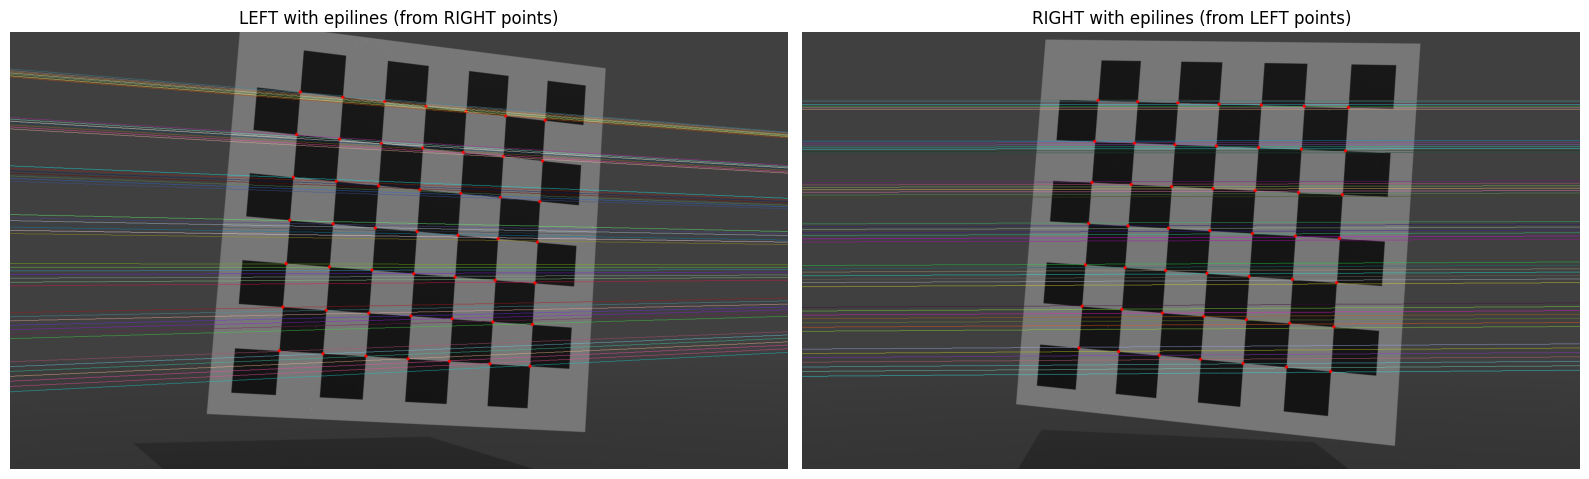

In [79]:
img_left_path  = "data/chessboards/c4Left.png"
img_right_path = "data/chessboards/c4Right.png"

detL = detect_chessboard_corners(img_left_path, pattern_size)
detR = detect_chessboard_corners(img_right_path, pattern_size)

if not (detL["success"] and detR["success"]):
    raise ValueError("Corners not detected in the chosen images")

ptsL = detL["corners"].reshape(-1, 2).astype(np.float32)
ptsR = detR["corners"].reshape(-1, 2).astype(np.float32)

imgL = detL["image_rgb"]
imgR = detR["image_rgb"]

# Choisis la F que tu veux valider :
F_use = F_st   # ou F_ransac

# 1) épilignes dans l'image DROITE à partir des points GAUCHE
imgR_epi = draw_epilines(imgL, imgR, ptsL, ptsR, F_use, which_image=1)

# 2) épilignes dans l'image GAUCHE à partir des points DROITE
imgL_epi = draw_epilines(imgR, imgL, ptsR, ptsL, F_use, which_image=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.imshow(imgL_epi); ax1.set_title("LEFT with epilines (from RIGHT points)"); ax1.axis("off")
ax2.imshow(imgR_epi); ax2.set_title("RIGHT with epilines (from LEFT points)"); ax2.axis("off")
plt.tight_layout()
plt.show()


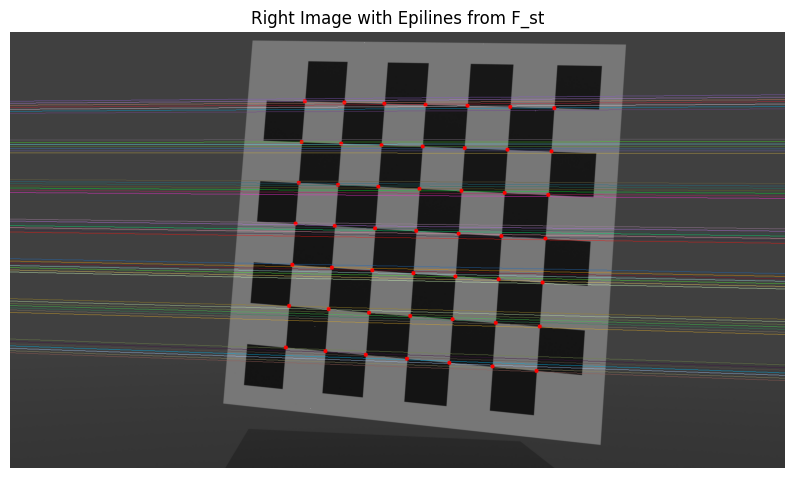

In [ ]:
# Sélection manuelle d'une paire stéréo
# Ex : c4Left / c4Right

img_left_path  = "data/chessboards/c4Left.png"
img_right_path = "data/chessboards/c4Right.png"

# Détection des coins
detL = detect_chessboard_corners(img_left_path, pattern_size)
detR = detect_chessboard_corners(img_right_path, pattern_size)

if not (detL["success"] and detR["success"]):
    raise ValueError("Corners not detected in the chosen images")

# Récupération des points
ptsL = detL["corners"].reshape(-1,2)
ptsR = detR["corners"].reshape(-1,2)
imgL = detL["image_rgb"]
imgR = detR["image_rgb"]


# Épilignes dans l'image DROITE
linesR = cv2.computeCorrespondEpilines(
    ptsL.reshape(-1,1,2), 1, F_st
).reshape(-1,3)

imgR_epi = imgR.copy()
h, w = imgR_epi.shape[:2]

# Tracer les épilignes et les points
for r, (x, y) in zip(linesR, ptsR):
    a,b,c = r
    x0,y0 = 0, int(-c/b)
    x1,y1 = w-1, int(-(a*(w-1)+c)/b)
    color = tuple(np.random.randint(0,255,3).tolist())
    cv2.line(imgR_epi, (x0,y0), (x1,y1), color, 1)
    cv2.circle(imgR_epi, (int(x),int(y)), 5, (255,0,0), -1)

plt.figure(figsize=(10,6))
plt.imshow(imgR_epi)
plt.title("Right Image with Epilines from F_st")
plt.axis("off")
plt.show()


R1=
 [[ 0.91792808  0.00811178  0.39666389]
 [-0.00801195  0.99996608 -0.0019087 ]
 [-0.39666591 -0.00142601  0.91796194]]
R2=
 [[ 9.99720178e-01 -4.10372775e-03  2.32964404e-02]
 [ 4.09798571e-03  9.99991560e-01  2.94212983e-04]
 [-2.32974511e-02 -1.98662176e-04  9.99728558e-01]]
P1=
 [[749.90341996   0.         363.27237344   0.        ]
 [  0.         749.90341996 541.73318863   0.        ]
 [  0.           0.           1.           0.        ]]
P2=
 [[ 7.49903420e+02  0.00000000e+00  3.63272373e+02 -6.15027421e+03]
 [ 0.00000000e+00  7.49903420e+02  5.41733189e+02  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]]
Q=
 [[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -3.63272373e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -5.41733189e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  7.49903420e+02]
 [ 0.00000000e+00  0.00000000e+00  1.21930079e-01 -0.00000000e+00]]
roi1: (355, 371, 825, 345) roi2: (34, 350, 702, 384)


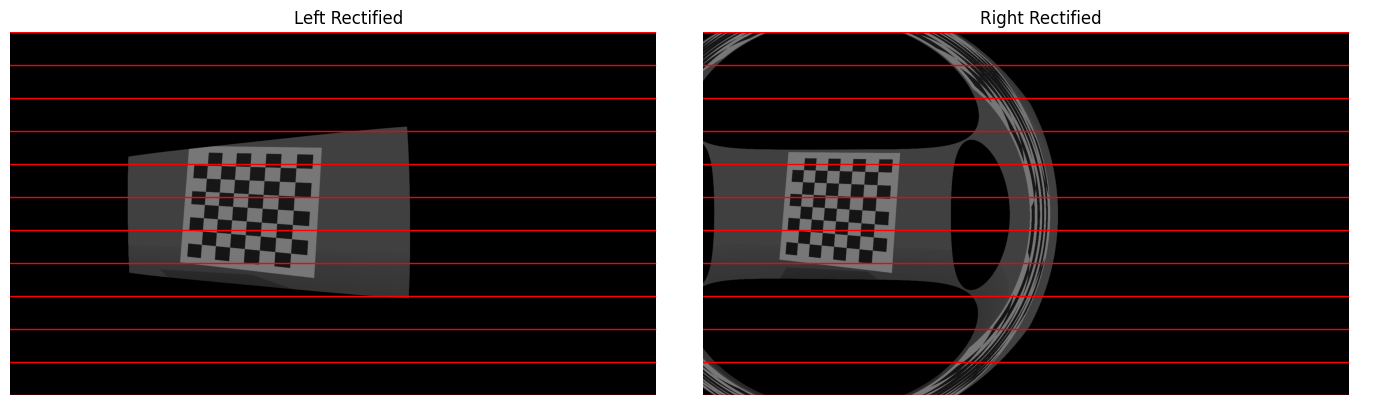

Mean |yL - yR| (px): 6.0389790534973145
Max  |yL - yR| (px): 13.2103271484375


In [81]:
# ============================================================
# BLOC — STEREO RECTIFY (complet)
# Objectif:
# - Rectifier les deux caméras: épipolaires horizontales
# - Obtenir R1, R2, P1, P2, Q
# - Construire les maps de rectification pour cv2.remap
# - Tester visuellement + numériquement (yL ~ yR)
# Prérequis:
# - cal_left["K"], cal_left["dist"], cal_right["K"], cal_right["dist"]
# - imsize (w,h)
# - R, T issus de stereoCalibrate (même convention partout)
# - pattern_size et detect_chessboard_corners déjà définis
# ============================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# ---------- 1) Paramètres stéréo ----------
K1, dist1 = cal_left["K"],  cal_left["dist"]
K2, dist2 = cal_right["K"], cal_right["dist"]

# Convention: on suppose ici que R,T représentent Left -> Right
# (Si tu as validé que c'était l'inverse, alors mets:
#   R_lr = R.T
#   T_lr = (-R.T @ T.reshape(3,1))
# )
R_lr = R.astype(np.float64)
T_lr = T.reshape(3,1).astype(np.float64)

# ---------- 2) Rectification ----------
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    K1, dist1, K2, dist2,
    imsize,
    R_lr, T_lr,
    flags=cv2.CALIB_ZERO_DISPARITY,  # centres alignés => épipolaires bien horizontales
    alpha=1                        # 0=crop fort (moins de bords noirs), 1=garde tout
)

print("R1=\n", R1)
print("R2=\n", R2)
print("P1=\n", P1)
print("P2=\n", P2)
print("Q=\n", Q)
print("roi1:", roi1, "roi2:", roi2)

# ---------- 3) Maps (undistort + rectify) ----------
# CV_16SC2 = format recommandé pour remap (rapide et stable)
map1, map2 = cv2.initUndistortRectifyMap(
    K1, dist1, R1, P1, imsize, cv2.CV_16SC2
)
map3, map4 = cv2.initUndistortRectifyMap(
    K2, dist2, R2, P2, imsize, cv2.CV_16SC2
)

def rectify_pair(left_path, right_path):
    imgL = cv2.imread(left_path)
    imgR = cv2.imread(right_path)
    if imgL is None:
        raise FileNotFoundError(f"Cannot read: {left_path}")
    if imgR is None:
        raise FileNotFoundError(f"Cannot read: {right_path}")

    rectL = cv2.remap(imgL, map1, map2, cv2.INTER_LINEAR)
    rectR = cv2.remap(imgR, map3, map4, cv2.INTER_LINEAR)
    return rectL, rectR

# ---------- 4) Test visuel (lignes horizontales) ----------
img_left_path  = "data/chessboards/c4Left.png"
img_right_path = "data/chessboards/c4Right.png"

Lr, Rr = rectify_pair(img_left_path, img_right_path)

Lrgb = cv2.cvtColor(Lr, cv2.COLOR_BGR2RGB)
Rrgb = cv2.cvtColor(Rr, cv2.COLOR_BGR2RGB)

h, w = Lrgb.shape[:2]
ys = np.linspace(0, h-1, 12).astype(int)

plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
plt.imshow(Lrgb)
plt.title("Left Rectified")
for y in ys:
    plt.plot([0, w], [y, y], 'r-', linewidth=1)
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(Rrgb)
plt.title("Right Rectified")
for y in ys:
    plt.plot([0, w], [y, y], 'r-', linewidth=1)
plt.axis("off")

plt.tight_layout()
plt.show()

# ---------- 5) Test numérique (preuve: yL ~ yR) ----------
# On détecte les coins sur les images rectifiées
tmpL = "_tmp_rectL.png"
tmpR = "_tmp_rectR.png"
cv2.imwrite(tmpL, Lr)
cv2.imwrite(tmpR, Rr)

dL = detect_chessboard_corners(tmpL, pattern_size)
dR = detect_chessboard_corners(tmpR, pattern_size)

if dL["success"] and dR["success"]:
    yL = dL["corners"].reshape(-1,2)[:,1]
    yR = dR["corners"].reshape(-1,2)[:,1]
    print("Mean |yL - yR| (px):", float(np.mean(np.abs(yL - yR))))
    print("Max  |yL - yR| (px):", float(np.max(np.abs(yL - yR))))
else:
    print("Corners not detected on rectified images (not fatal).")

# Nettoyage fichiers temporaires
try:
    os.remove(tmpL)
    os.remove(tmpR)
except:
    pass


# Sauvegarde

In [13]:
np.savez("calib_left.npz",  K=cal_left["K"],  dist=cal_left["dist"],  image_size=np.array(cal_left["image_size"]))
np.savez("calib_right.npz", K=cal_right["K"], dist=cal_right["dist"], image_size=np.array(cal_right["image_size"]))


# rectification


In [14]:

# 8 Stereo Rectification
R1, R2, P1, P2, Q, roi1, roi2 = cv2.stereoRectify(
    K1, dist1, K2, dist2, imsize,
    R, T,
    alpha=0  # 0 = recadrage auto (moins de black borders)
)

# Création des maps (undistort + rectify)
map1x, map1y = cv2.initUndistortRectifyMap(
    K1, dist1, R1, P1, imsize, cv2.CV_32FC1
)
map2x, map2y = cv2.initUndistortRectifyMap(
    K2, dist2, R2, P2, imsize, cv2.CV_32FC1
)

def rectify_pair(left_path, right_path):
    imgL = cv2.imread(left_path)
    imgR = cv2.imread(right_path)
    rectL = cv2.remap(imgL, map1x, map1y, cv2.INTER_LINEAR)
    rectR = cv2.remap(imgR, map2x, map2y, cv2.INTER_LINEAR)
    return rectL, rectR


# Reprojection in 3D

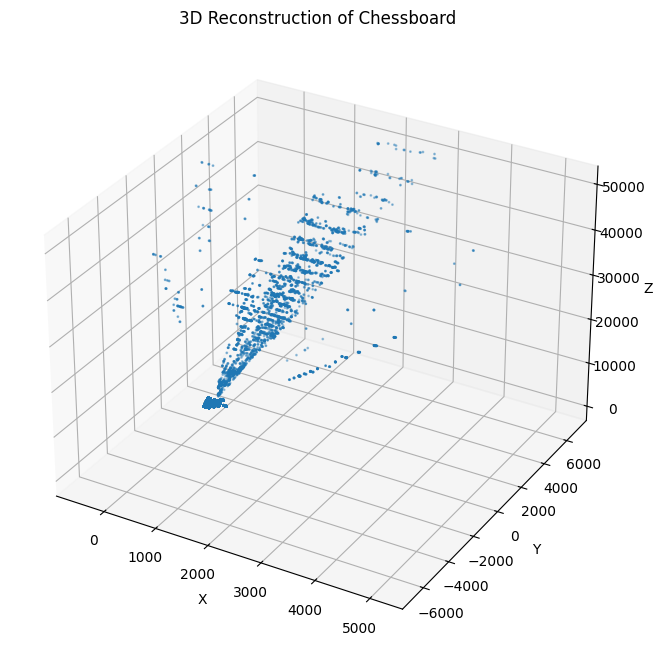

In [17]:
# Reprojection 3D

points_3D = cv2.reprojectImageTo3D(disp, Q)

mask = disp > disp.min()
X = points_3D[:,:,0][mask]
Y = points_3D[:,:,1][mask]
Z = points_3D[:,:,2][mask]

# Visualisation du nuage 3D
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, Z, s=1)
ax.set_title("3D Reconstruction of Chessboard")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()


In [84]:
F, inliers = cv2.findFundamentalMat(
    pts1, pts2,
    method=cv2.FM_RANSAC,
    ransacReprojThreshold=1.0,
    confidence=0.999
)
inliers = inliers.ravel().astype(bool)
print("F =\n", F)
print("Inliers:", inliers.sum(), "/", len(inliers))

# Vérif rapide: x2^T F x1 ≈ 0
x1 = np.hstack([pts1[inliers], np.ones((inliers.sum(),1))])
x2 = np.hstack([pts2[inliers], np.ones((inliers.sum(),1))])
residuals = np.abs(np.sum(x2 @ F * x1, axis=1))  # |x2^T F x1|
print("Mean |x2^T F x1| on inliers:", float(residuals.mean()))


F =
 [[ 6.91712246e-10  7.73191851e-07 -5.03599706e-04]
 [ 8.53877249e-07 -5.46194538e-09 -9.34400032e-03]
 [-5.48627083e-04  7.80302481e-03  1.00000000e+00]]
Inliers: 147 / 147
Mean |x2^T F x1| on inliers: 0.00041475302846778457


# Détecter la ligne laser rouge (scan laser)

On seuillle le rouge en HSV (deux plages autour de 0° et 180°), puis on prend un point par ligne (centre de gravité) pour avoir une courbe fine (échantillonnage). C’est demandé pour guider l’appariement.

“On isole le laser rouge (HSV) et on réduit à un point par ligne → une courbe 2D propre pour matcher.”

On seuillle le rouge (HSV) et on prend un point par ligne → la courbe laser

# Apparier les points gauche/droite (épipolaires)

Pour chaque point gauche x, on calcule ℓ′=Fx et on prend sur la courbe droite le point le plus proche de cette droite (distance point–droite).


On contraint l’appariement par la droite épipolaire calculée via F ; puis on triangule avec P_g, P_d pour obtenir (X,Y,Z)

Pour chaque point gauche, on cherche sur la droite épipolaire droite le point le plus proche.




In [19]:
LEFT_DIR  = Path("data/scanLeft")
RIGHT_DIR = Path("data/scanRight")

def index_left(path):
    # "0012.png" -> 12
    m = re.search(r'(\d+)\.png$', os.path.basename(path))
    return int(m.group(1)) if m else None

def index_right(path):
    # "scan0012.png" -> 12
    m = re.search(r'scan0*(\d+)\.png$', os.path.basename(path), flags=re.I)
    return int(m.group(1)) if m else None

def build_pairs(left_dir=LEFT_DIR, right_dir=RIGHT_DIR):
    L = {index_left(p): p for p in glob.glob(str(left_dir / "*.png")) if index_left(p) is not None}
    R = {index_right(p): p for p in glob.glob(str(right_dir / "scan*.png")) if index_right(p) is not None}
    common = sorted(set(L.keys()) & set(R.keys()))
    pairs = [(L[i], R[i]) for i in common]
    print(f"Found {len(pairs)} stereo scan pairs (common indices: {common[:8]}{'...' if len(common)>8 else ''})")
    return pairs

scan_pairs = build_pairs()


Found 26 stereo scan pairs (common indices: [0, 1, 2, 3, 4, 5, 6, 7]...)


# Détection du laser rouge (HSV) → 1 point par ligne

In [20]:
import numpy as np
import cv2

def extract_laser_points_one_per_row(img_bgr, min_area_px=3):
    """Retourne un array N×2 de points (x,y) : 1 point (barycentre) par ligne où du rouge est détecté."""
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # Deux plages de rouge (0° et 180°)
    lower1 = np.array([0,   120, 120], np.uint8)
    upper1 = np.array([10,  255, 255], np.uint8)
    lower2 = np.array([170, 120, 120], np.uint8)
    upper2 = np.array([180, 255, 255], np.uint8)

    mask = cv2.inRange(hsv, lower1, upper1) | cv2.inRange(hsv, lower2, upper2)

    # Nettoyage léger
    mask = cv2.medianBlur(mask, 3)
    kernel = np.ones((3,3), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=1)

    ys, xs = np.where(mask > 0)
    if len(xs) == 0:
        return np.empty((0,2), dtype=np.float32)

    # Regrouper par ligne y → barycentre x
    pts = {}
    for y, x in zip(ys, xs):
        pts.setdefault(int(y), []).append(int(x))

    rows = sorted(pts.keys())
    out = []
    for y in rows:
        xs_row = np.array(pts[y], dtype=np.float32)
        if xs_row.size >= min_area_px:
            x_mean = float(xs_row.mean())
            out.append([x_mean, float(y)])

    return np.array(out, dtype=np.float32)


# Appariement gauche/droite après rectification

Après rectification, les épipolaires sont horizontales ⇒ on matche par même y.
On associe chaque point gauche (xL, y) au point droit (xR, y) le plus proche (tolérance en pixels).

In [21]:
def match_rows_by_y(ptsL, ptsR, y_tol=0.5):
    """
    Associe points par ligne : pour chaque y de L, on prend le point de R
    dont y est à |Δy| <= y_tol (0.5 px par défaut) et qui minimise |xL - xR|.
    Retourne (matched_L, matched_R) de taille M×2.
    """
    if ptsL.size == 0 or ptsR.size == 0:
        return np.empty((0,2), np.float32), np.empty((0,2), np.float32)

    # indexer R par y entier
    from collections import defaultdict
    rowsR = defaultdict(list)
    for x, y in ptsR:
        rowsR[int(round(y))].append((x, y))

    L_list, R_list = [], []
    for xL, yL in ptsL:
        yr = int(round(yL))
        candidates = []
        # on regarde yr-1, yr, yr+1 pour tolérance subpixel
        for yy in (yr-1, yr, yr+1):
            for xR, yR in rowsR.get(yy, []):
                if abs(yR - yL) <= y_tol:
                    candidates.append((xR, yR))
        if candidates:
            # choisir le plus proche en x
            xR, yR = min(candidates, key=lambda p: abs(p[0] - xL))
            L_list.append([xL, yL])
            R_list.append([xR, yR])

    if not L_list:
        return np.empty((0,2), np.float32), np.empty((0,2), np.float32)
    return np.array(L_list, np.float32), np.array(R_list, np.float32)


# Triangulation 3D

On triangule les paires correspondantes avec les matrices de projection P.


In [23]:
def triangulate_rectified(P1, P2, ptsL, ptsR):
    """ptsL/ptsR: N×2 rectifiés. Retourne N×3 en coordonnées homogènes normalisées."""
    if ptsL.shape[0] == 0:
        return np.empty((0,3), np.float32)
    pl = ptsL.T  # 2×N
    pr = ptsR.T
    pts4 = cv2.triangulatePoints(P1, P2, pl, pr)  # 4×N
    pts3 = (pts4[:3] / pts4[3]).T                  # N×3
    return pts3.astype(np.float32)


# Boucle principale sur toutes les paires + export .ply

Total 3D points: 1598


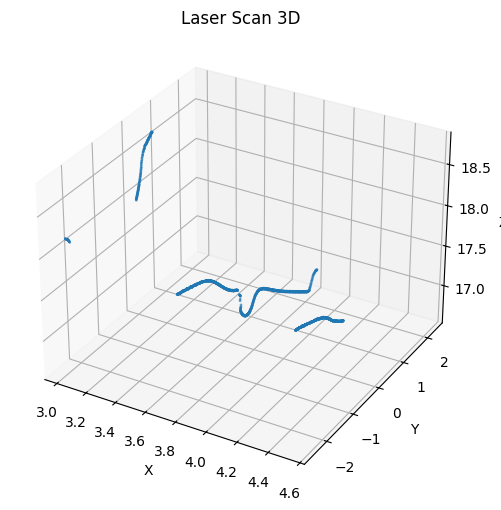

PLY saved: laser_scan.ply


In [24]:
def save_ply_xyzrgb(path, X, rgb=None):
    """
    Sauve un nuage de points en .ply (ASCII).
    X: N×3, rgb: N×3 uint8 ou None (dans ce cas blanc).
    """
    X = np.asarray(X)
    N = X.shape[0]
    if rgb is None:
        rgb = np.full((N,3), 255, dtype=np.uint8)
    with open(path, "w") as f:
        f.write("ply\nformat ascii 1.0\n")
        f.write(f"element vertex {N}\n")
        f.write("property float x\nproperty float y\nproperty float z\n")
        f.write("property uchar red\nproperty uchar green\nproperty uchar blue\n")
        f.write("end_header\n")
        for (x,y,z), (r,g,b) in zip(X, rgb):
            f.write(f"{x} {y} {z} {int(r)} {int(g)} {int(b)}\n")

all_pts3d = []

for lp, rp in scan_pairs:
    # 1) Rectifier
    Lr, Rr = rectify_pair(lp, rp)

    # 2) Extraire laser (1 pt / ligne)
    ptsL = extract_laser_points_one_per_row(Lr)
    ptsR = extract_laser_points_one_per_row(Rr)

    # 3) Appariement par ligne (rectifié ⇒ même y)
    mL, mR = match_rows_by_y(ptsL, ptsR, y_tol=0.5)

    # 4) Triangulation
    P_left, P_right = P1, P2  # matrices de projection rectifiées
    X3 = triangulate_rectified(P_left, P_right, mL, mR)

    if X3.shape[0]:
        all_pts3d.append(X3)

# Concaténer toutes les tranches (scan)
if all_pts3d:
    cloud = np.vstack(all_pts3d)
    print("Total 3D points:", cloud.shape[0])

    # Affichage rapide
    from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
    import matplotlib.pyplot as plt

    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(cloud[:,0], cloud[:,1], cloud[:,2], s=1)
    ax.set_title("Laser Scan 3D")
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")
    plt.show()

    # Export PLY
    save_ply_xyzrgb("laser_scan.ply", cloud)
    print("PLY saved: laser_scan.ply")
else:
    print("Aucun point 3D reconstruit (vérifier seuillage rouge / indices communs).")


# Affichage du nuage 3D

On affiche le nuage de points 3D reconstruit

Ce que tu dis à l’oral (ultra court, étape par étape)

Calibration : “Coins damier → calibrateCamera → K, dist, (R,t), puis P = K[R|t].”

F & épipolaires : “Estimée via findFundamentalMat (RANSAC). Contrainte 
x′TFx=0. computeCorrespondEpilines pour tracer les droites.”

Laser : “Seuil HSV (deux plages rouge) → un point moyen par ligne (échantillonnage).”


Appariement : “Pour chaque point gauche, on choisit sur la droite épipolaire droite le point de la courbe le plus proche.”

Triangulation : “Avec P_g, P_d, triangulatePoints fournit les points 3D; on affiche le nuage.”